## Imports

In [84]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display

In [85]:
PATH_TRAIN_DATA = "musicnet/train_data/"
PATH_TRAIN_LABELS = "musicnet/train_labels/"
PATH_TEST_DATA = "musicnet/test_data/"
PATH_TEST_LABELS = "musicnet/test_labels/"
PATH_METADATA = "musicnet_metadata.csv"

In [86]:
metadata = pd.read_csv(PATH_METADATA)
metadata.drop(metadata[metadata["ensemble"] != "Solo Piano"].index, inplace = True)

In [87]:
# Load wav files, downsample the contents, compute their CQT spectrum, and save it with the same name to the same location as a binary file
# Following this: http://cs229.stanford.edu/proj2017/final-reports/5242716.pdf
ORIGINAL_SR = 44100
TARGET_SR = 16000
FMIN = librosa.note_to_hz('A0')
FMIN_MIDI_INDEX = 21
N_NOTES = 84
N_OCTAVES = 7
BINS_PER_NOTE = 1
BINS_PER_OCTAVE = 12*BINS_PER_NOTE
N_BINS = N_OCTAVES*BINS_PER_OCTAVE

FRAME_LENGTH = 2048
HOP_LENGTH = 512

ids = metadata['id'].to_numpy()
"""
for id in ids:
    path="PATH_TRAIN_DATA"+str(id)
    if os.path.isfile(path+".wav") and not os.path.isfile(path+".npy"):
        data, sr = librosa.load(path+".wav")
        data_downsampled = librosa.resample(data, orig_sr=sr, target_sr=TARGET_SR, res_type='kaiser_fast')
        data_cqt = np.abs(librosa.cqt(data_downsampled, sr=TARGET_SR, hop_length=HOP_LENGTH, fmin=FMIN, n_bins=N_BINS, bins_per_octave=BINS_PER_OCTAVE))
        np.save(path,data_cqt)
"""


'\nfor id in ids:\n    path="PATH_TRAIN_DATA"+str(id)\n    if os.path.isfile(path+".wav") and not os.path.isfile(path+".npy"):\n        data, sr = librosa.load(path+".wav")\n        data_downsampled = librosa.resample(data, orig_sr=sr, target_sr=TARGET_SR, res_type=\'kaiser_fast\')\n        data_cqt = np.abs(librosa.cqt(data_downsampled, sr=TARGET_SR, hop_length=HOP_LENGTH, fmin=FMIN, n_bins=N_BINS, bins_per_octave=BINS_PER_OCTAVE))\n        np.save(path,data_cqt)\n'

In [88]:
filename = str(ids[0])
print("filename: ", filename)

#librosa.load automatically resamples to 22.5Hz, we can change that value to our target sample rate
#data, sr = librosa.load(PATH_TRAIN_DATA + filename + ".wav", sr=TARGET_SR, res_type='kaiser_fast')
data, sr = librosa.load(PATH_TRAIN_DATA + filename + ".wav", sr=None)
data_downsampled = librosa.resample(data, orig_sr=sr, target_sr=TARGET_SR, res_type='kaiser_fast')
print("shape: ", data.shape)
print("downsampled shape: ", data_downsampled.shape)
print("sample rate: ", sr)
print("downsampled sample rate: ", TARGET_SR)
print("duration (s): ", float(len(data)/sr))
print("downsampled duration (s): ", float(len(data_downsampled)/TARGET_SR))

data_cqt = np.abs(librosa.cqt(data_downsampled, sr=TARGET_SR, hop_length=HOP_LENGTH, fmin=FMIN, n_bins=N_BINS, bins_per_octave=BINS_PER_OCTAVE))
print("cqt shape: ", data_cqt.shape)
print("cqt frame duration (ms): ", (1000*HOP_LENGTH)/TARGET_SR)
print("cqt duration (s): ", (data_cqt.shape[1]*HOP_LENGTH)/TARGET_SR)

np.save(PATH_TRAIN_DATA+filename,data_cqt)

filename:  1733
shape:  (24079104,)
downsampled shape:  (8736183,)
sample rate:  44100
downsampled sample rate:  16000
duration (s):  546.0114285714286
downsampled duration (s):  546.0114375
cqt shape:  (84, 17063)
cqt frame duration (ms):  32.0
cqt duration (s):  546.016


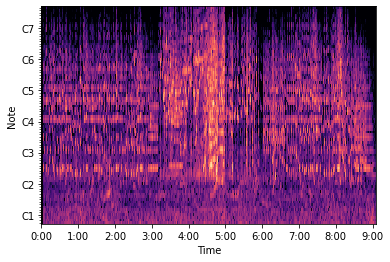

In [89]:
librosa.display.specshow(librosa.amplitude_to_db(data_cqt, ref=np.max), sr=TARGET_SR, hop_length=HOP_LENGTH, fmin=FMIN, bins_per_octave=BINS_PER_OCTAVE, x_axis='time', y_axis='cqt_note')

In [90]:
labels = np.zeros((data_cqt.shape[1], data_cqt.shape[0]))
labels_file = np.loadtxt(PATH_TRAIN_LABELS + filename + ".csv", delimiter=",", usecols=[0,1,3], skiprows=1)
frac_sr = TARGET_SR/sr
sample_index = frac_sr/HOP_LENGTH

for line in labels_file:
    initial_frame = round(line[0]*sample_index)
    final_frame = round(line[1]*sample_index)
    pitch = round(line[2]-FMIN_MIDI_INDEX)
    labels[initial_frame:final_frame,pitch] = 1
    
np.save(PATH_TRAIN_LABELS+filename,labels)

In [91]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler

In [92]:
model = Sequential()
model.add(Dense(256, activation=tf.nn.relu, input_shape=(N_NOTES,)))
model.add(Dense(N_NOTES, activation=tf.nn.sigmoid))

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               21760     
                                                                 
 dense_7 (Dense)             (None, 84)                21588     
                                                                 
Total params: 43,348
Trainable params: 43,348
Non-trainable params: 0
_________________________________________________________________


In [93]:
x_train = np.load(PATH_TRAIN_DATA+filename+ ".npy" ).transpose()
y_train = np.load(PATH_TRAIN_LABELS+filename+ ".npy" )

x_test = np.load(PATH_TRAIN_DATA+filename+ ".npy" ).transpose()
y_test = np.load(PATH_TRAIN_LABELS+filename+ ".npy" )

In [94]:
print(x_train.shape)
print(y_train.shape)

(17063, 84)
(17063, 84)


In [95]:
dnn_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=100)

Epoch 1/10
171/171 [==============================] - 1s 3ms/step - loss: 0.0749 - accuracy: 0.3814 - val_loss: 0.0532 - val_accuracy: 0.4317
Epoch 2/10
171/171 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 0.4411 - val_loss: 0.0491 - val_accuracy: 0.4430
Epoch 3/10
171/171 [==============================] - 1s 3ms/step - loss: 0.0483 - accuracy: 0.4435 - val_loss: 0.0457 - val_accuracy: 0.4798
Epoch 4/10
171/171 [==============================] - 0s 3ms/step - loss: 0.0461 - accuracy: 0.4415 - val_loss: 0.0429 - val_accuracy: 0.4419
Epoch 5/10
171/171 [==============================] - 0s 3ms/step - loss: 0.0446 - accuracy: 0.4361 - val_loss: 0.0426 - val_accuracy: 0.4425
Epoch 6/10
171/171 [==============================] - 0s 3ms/step - loss: 0.0433 - accuracy: 0.4448 - val_loss: 0.0418 - val_accuracy: 0.4399
Epoch 7/10
171/171 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.4408 - val_loss: 0.0413 - val_accuracy: 0.4029
Epoch 